In [1]:
from IPython import display
import time
import tensorflow as tf
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cross_validation import train_test_split
from skimage import transform, io, color, feature
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid': False})

/home/naotoyoshida/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
PATH_IMG = "/home/naotoyoshida/udacity/Self-Driving-Car-Behavior-Cloning/drivedata/"
CSV_PATH = 'drivedata/driving_log.csv'
data = pd.read_csv(CSV_PATH,
                names=['img_center', 'img_left', 'img_right',
                        'steer_angle', 'throttle', 'brake', 'speed'],
                sep=', ', engine='python')

print(data[:3])
data.reindex(np.random.permutation(data.index)).reset_index(drop=True)

# remove zero-steering
msk = np.abs(data['steer_angle']) > 0.00001
data_nonzeroXc = data['img_center'][msk]
data_nonzeroXl = data['img_left'][msk]
data_nonzeroXr = data['img_right'][msk]
data_nonzeroy = data['steer_angle'][msk]

# get train-test split mask
msk = np.linspace(0,1,len(data_nonzeroy)) < 0.8
# Trainnig data with data augumentation
Xc_train_info = data_nonzeroXc[msk].as_matrix()
Xl_train_info = data_nonzeroXl[msk].as_matrix()
Xr_train_info = data_nonzeroXr[msk].as_matrix()
X_train_info = np.concatenate((Xc_train_info, Xl_train_info, Xr_train_info))
y_train_info = data_nonzeroy[msk].as_matrix()
y_train_info = np.concatenate((y_train_info,
                               y_train_info + 0.2,
                               y_train_info - 0.2))

# Validation Data without data augumentation
X_val_info = data_nonzeroXc[~msk].as_matrix()
y_val_info = data_nonzeroy[~msk].as_matrix()

print(Xc_train_info.shape)
print(X_train_info.shape)
print(y_train_info.shape)
print(X_val_info.shape)
print(y_val_info.shape)
print("train")
print(X_train_info[:3])
print(y_train_info[:10])
print("val")
print(X_val_info[:3])
print(y_val_info[:10])

n_train = X_train_info.shape[0]
n_val = X_val_info.shape[0]

                                          img_center  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   

                                            img_left  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...   

                                           img_right  steer_angle  throttle  \
0  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   
1  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   
2  /home/naotoyoshida/udacity/Self-Driving-Car-Be...          0.0       0.0   

   brake     speed  
0      0  2.190392  
1      0  2.166651  
2      0  2.143156  
(2509,)
(7527,)
(7527,)
(627,)
(627,)
train
[ '/home/naotoyoshida/udacity/Self-Driving-Car-Behavior-Cloning/drivedata/IMG/center_2017_02_05_23_23_09_

[[[  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  5.99007843e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.41513725e-01  -6.09561498e-02   4.86462000e-03]
  [  4.71333333e-01  -7.17710128e-02   2.78666337e-03]
  [  3.91113725e-01  -7.86103908e-02   4.35545176e-03]]

 [[  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  [  6.02929412e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.46843137e-01  -6.55086590e-02   3.62954314e-03]
  [  3.71505882e-01  -7.86103908e-02   4.35545176e-03]
  [  3.14090196e-01  -8.31629001e-02   3.12037490e-03]]

 [[  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  [  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  [  6.06850980e-01   9.31209109e-02  -9.20183852e-02]
  ..., 
  [  4.94862745e-01  -7.17710128e-02   2.78666337e-03]
  [  3.80309804e-01  -8.48727446e-02   3.51257200e-03]
  [  3.36278431e-01  -8.82924336e-02 

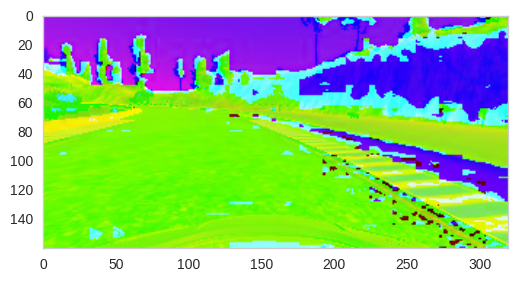

In [3]:
#img = io.imread(PATH_IMG+X_train_info[0])[50:,:,:]
img = io.imread(X_train_info[0])#[50:,:,:]
img=color.rgb2yuv(img)
plt.imshow(img)
print(img)
print(img.shape)

In [4]:
# Parameters

IMG_SIZE = (50, 100)
CHANNEL_SIZE = 3
BATCH_SIZE = 32
N_EPOCH = 5000

In [5]:
# Utility Functions
def get_formatted_image(img_path):
    img = color.rgb2yuv(io.imread(img_path)[50:,:,:])
    return transform.resize(image=img, output_shape=IMG_SIZE)

def get_single_data(index, info_tuple):
    data_x, data_y = info_tuple
    path = data_x[index]
    #path = PATH_IMG + data_x[index]
    X_img = np.ndarray(shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE))
    X_img = get_formatted_image(path)
    return X_img, data_y[index]

(x, y) = get_single_data(10, (X_val_info, y_val_info))
(x, y) = get_single_data(0, (X_train_info, y_train_info))
print(x.shape)
print(y)

def get_whole_data(is_train):
    if is_train is True:
        n = n_train
        info_tuple = (X_train_info, y_train_info)
    else:
        n = n_val
        info_tuple = (X_val_info, y_val_info)
    X = np.ndarray(shape=(n, IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE)).astype(np.float32)
    Y = np.ndarray(shape=(n, 1)).astype(np.float32)
    for i in range(n):
        x, y = get_single_data(i, info_tuple)
        if CHANNEL_SIZE == 1:
            X[i,:,:,0] = x
        else:
            X[i,:,:,:] = x
        Y[i] = y
    return X, Y


X_train, y_train = get_whole_data(is_train=True)
X_val, y_val = get_whole_data(is_train=False)

(50, 100, 3)
-0.07362056


(7527, 50, 100, 3)
(627, 50, 100, 3)


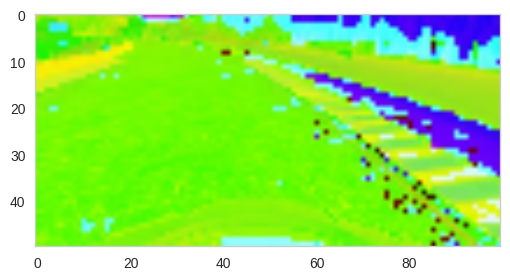

In [6]:
print(X_train.shape)
print(X_val.shape)
plt.imshow(X_train[0,:,:,:])

In [7]:
# Train by keras anyway
import tensorflow as tf
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Convolution2D(32, 4, 4,
                        border_mode='valid',
                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], CHANNEL_SIZE),
                        dim_ordering="tf",
                        subsample=(2,2)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(64, 4, 4,
                        dim_ordering="tf",
                        subsample=(2,2)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Convolution2D(128, 3, 3,
                        dim_ordering="tf",
                        subsample=(1,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('tanh'))

model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 24, 49, 32)    1568        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 24, 49, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 24, 49, 32)    128         activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 11, 23, 64)    32832       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [ ]:
from keras.optimizers import Adam

optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error',
              optimizer=optimizer)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras

sns.set_style("darkgrid", {'axes.grid': True})

"""
cbk = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#cbk_es = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
cbk_cp = keras.callbacks.ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

model.fit_generator(data_generator(is_train=True),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=N_EPOCH,
                    validation_data=data_generator(is_train=False),
                    nb_val_samples=X_val.shape[0],
                    callbacks=[cbk, cbk_cp])

"""

datagen = ImageDataGenerator(
    rotation_range=30.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1)

# fits the model on batches with real-time data augmentation:
cbk = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
cbk_cp = keras.callbacks.ModelCheckpoint('./models/model.h5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True),
                    samples_per_epoch=len(X_train),
                    nb_epoch=N_EPOCH,
                    validation_data=(X_val, y_val),
                    nb_val_samples=len(X_val),
                    callbacks=[cbk, cbk_cp])
    
model.save('model.h5')

Instructions for updating:
Please switch to tf.summary.merge_all.
Epoch 1/1000
7527/7527 [==============================] - 7s - loss: 0.6455 - val_loss: 0.4885
Epoch 2/1000
7527/7527 [==============================] - 7s - loss: 0.6436 - val_loss: 0.3377
Epoch 3/1000
7527/7527 [==============================] - 7s - loss: 0.6145 - val_loss: 0.2647
Epoch 4/1000
7527/7527 [==============================] - 7s - loss: 0.5984 - val_loss: 0.2581
Epoch 5/1000
7527/7527 [==============================] - 7s - loss: 0.5790 - val_loss: 0.2578
Epoch 6/1000
7527/7527 [==============================] - 8s - loss: 0.5745 - val_loss: 0.1884
Epoch 7/1000
7527/7527 [==============================] - 7s - loss: 0.5503 - val_loss: 0.1666
Epoch 8/1000
7527/7527 [==============================] - 7s - loss: 0.5379 - val_loss: 0.1575
Epoch 9/1000
7527/7527 [==============================] - 7s - loss: 0.5243 - val_loss: 0.1327
Epoch 10/1000
7527/7527 [==============================] - 7s - loss: 0.4953 - 

In [ ]:
"""
from keras.applications.vgg19 import VGG19

base_model = VGG19(weights='imagenet')

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)
"""